In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import models

In [2]:
CATEGORIES = ['Black-grass',
          'Charlock',
          'Cleavers',
          'Common Chickweed',
          'Common wheat',
          'Fat Hen',
          'Loose Silky-bent',
          'Maize',
          'Scentless Mayweed',
          'Shepherds Purse',
          'Small-flowered Cranesbill',
          'Sugar beet']

IMG_SIZE=300

DATADIR  = 'D:/project/dataset/train'
DATADIR_TEST  = 'D:/project/dataset/test'

In [3]:
TRAIN_DATA_DIR = DATADIR
batch_size = 16
# create data generators
def data_generators():

    # apply random transformations on training data
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split = 0.1,
    )
    test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=preprocess_input)
    
    train_gen = train_data_generator.flow_from_directory(
        directory = TRAIN_DATA_DIR,
        target_size = (IMG_SIZE, IMG_SIZE),
        color_mode = 'rgb',
        class_mode = "categorical",
        batch_size = batch_size,
        subset = 'training',
    )

    # define validation data generator
    validation_gen = train_data_generator.flow_from_directory(
        directory = TRAIN_DATA_DIR,
        color_mode = 'rgb',
        class_mode = "categorical",
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        subset = 'validation',
        shuffle=False
    )
    test_gen = test_data_generator.flow_from_directory(
        directory= 'D:/project/dataset',
        classes=['test'],
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        color_mode='rgb',
        shuffle=False,
        class_mode='categorical')
    return train_gen, validation_gen, test_gen
train_gen, validation_gen, test_gen = data_generators()

Found 4279 images belonging to 12 classes.
Found 471 images belonging to 12 classes.
Found 794 images belonging to 1 classes.


In [4]:
print(train_gen.class_indices)

{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}


In [5]:
resnet_model = Sequential()
pretrained_model=ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet')

In [6]:
resnet_model = Sequential()
pretrained_model=ResNet50(include_top = False, input_shape=(IMG_SIZE,IMG_SIZE,3), pooling = 'avg', classes=100, weights = 'imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024,"relu"))
resnet_model.add(Dense(512,"relu"))
resnet_model.add(Dense(128,"relu"))
resnet_model.add(Dense(12, activation ='softmax'))

In [7]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 12)                1548      
                                                                 
Total params: 26,277,900
Trainable params: 2,690,188
N

In [8]:
resnet_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
# save best model regularly
save_best_model = tf.keras.callbacks.ModelCheckpoint(filepath = 'best.h5',monitor = 'val_accuracy', 
                                                     save_best_only = True, verbose = 1,mode='max')
# reduce learning rate when it stops decreasing
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4,patience = 3,
                                                 min_lr = 1e-10, verbose = 1, cooldown = 1)
# stop training early if no further improvement
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 1e-2, patience = 10, verbose = 1,
        mode = 'max', baseline = None, restore_best_weights = True)
callback=[save_best_model, reduce_lr, early_stopping]

In [10]:
history = resnet_model.fit(train_gen,
          epochs = 100,
          steps_per_epoch=train_gen.samples // batch_size,
          validation_data = validation_gen,
          validation_steps = validation_gen.samples // batch_size,
          callbacks=callback)

Epoch 1/100
267/267 [==============================] - ETA: 0s - loss: 1.3970 - accuracy: 0.5135
Epoch 1: val_accuracy improved from -inf to 0.70690, saving model to best.h5
267/267 [==============================] - 485s 2s/step - loss: 1.3970 - accuracy: 0.5135 - val_loss: 0.8706 - val_accuracy: 0.7069 - lr: 0.0010
Epoch 2/100
267/267 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.7183
Epoch 2: val_accuracy improved from 0.70690 to 0.74784, saving model to best.h5
267/267 [==============================] - 412s 2s/step - loss: 0.7858 - accuracy: 0.7183 - val_loss: 0.7082 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 3/100
267/267 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7647
Epoch 3: val_accuracy improved from 0.74784 to 0.79310, saving model to best.h5
267/267 [==============================] - 404s 2s/step - loss: 0.6605 - accuracy: 0.7647 - val_loss: 0.6011 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 4/100
267/267 [================

In [11]:
model = models.load_model('best.h5')

In [12]:
model.evaluate(test_gen)

794/794 [==============================] - 89s 111ms/step - loss: 196.6190 - accuracy: 0.0264


[196.6190185546875, 0.026448363438248634]

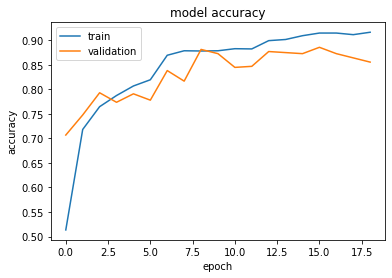

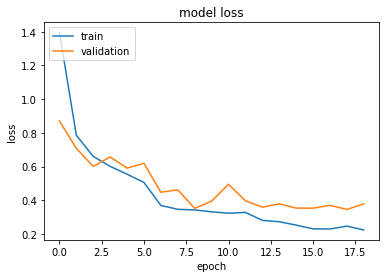

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
Y_pred = model.predict_generator( validation_gen, validation_gen.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_gen.classes, y_pred))

C:\Users\farhe\AppData\Local\Temp\ipykernel_13436\3071142573.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator( validation_gen, validation_gen.samples // batch_size+1)


Confusion Matrix
[[15  0  0  0  0  0 11  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 25  0  1  0  0  0  1  0  0  0]
 [ 0  0  0 59  0  0  0  0  2  0  0  0]
 [ 1  0  0  0 20  0  1  0  0  0  0  0]
 [ 0  0  0  2  0 42  1  0  0  0  0  2]
 [10  0  0  0  0  1 54  0  0  0  0  0]
 [ 0  0  0  0  1  0  1 19  1  0  0  0]
 [ 0  0  0  1  0  0  0  0 48  2  0  0]
 [ 0  0  0  2  0  0  0  0  6 14  1  0]
 [ 0  0  0  1  0  0  0  0  1  0 47  0]
 [ 1  0  0  0  2  0  0  1  0  0  0 34]]


In [16]:
print('Classification Report')
print(classification_report(validation_gen.classes, y_pred, target_names=CATEGORIES))

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.56      0.58      0.57        26
                 Charlock       0.97      1.00      0.99        39
                 Cleavers       1.00      0.89      0.94        28
         Common Chickweed       0.91      0.97      0.94        61
             Common wheat       0.83      0.91      0.87        22
                  Fat Hen       0.98      0.89      0.93        47
         Loose Silky-bent       0.79      0.83      0.81        65
                    Maize       0.95      0.86      0.90        22
        Scentless Mayweed       0.81      0.94      0.87        51
          Shepherds Purse       0.88      0.61      0.72        23
Small-flowered Cranesbill       0.98      0.96      0.97        49
               Sugar beet       0.94      0.89      0.92        38

                 accuracy                           0.88       471
                macro avg       0.88  